In [83]:
import dateutil
import matplotlib.pyplot as plt
import pandas
import re
import requests
import seaborn

from collections import Counter
from datetime import datetime
from user_agent import generate_user_agent
from bs4 import BeautifulSoup

In [4]:
keyword = 'Django'
area = 2  # 1 - MSK, 2 - SPB
salary = 120 * 1000  # RUR

In [6]:
BASE_URL = 'https://api.hh.ru'

In [10]:
params = dict(
    order_by='salary_desc',
    text=keyword,
    area=area,
    period=30, # days
    per_page=100,
    no_magic='false',  # disable magic
    vacancy_search_fields='description',  # available: name, description, company_name
)
response = requests.get(
    BASE_URL + '/vacancies',
    headers={'User-Agent': generate_user_agent()},
    params=params,
)
response

<Response [200]>

## Main info

In [25]:
items = response.json()['items']
vacancies = []
for item in items:
    vacancies.append(dict(
        id=item['id'],
        name=item['name'],
        salary_from=item['salary']['from'] if item['salary'] else None,
        salary_to=item['salary']['to'] if item['salary'] else None,
        created=item['published_at'],
        company=item['employer']['name'],
        company_id=item['employer']['id'],
    ))

vacancies = pandas.DataFrame(
    vacancies,
    columns=['id', 'name', 'salary_from', 'salary_to', 'created', 'company_id', 'company'],
)

In [26]:
vacancies.head()

,id,name,salary_from,salary_to,created,company_id,company
0,21072095,Senior Backend Developer (Кипр),3000.0,NaN,2018-04-03T13:00:40+0300,1818108,IBIT
1,24827105,Back-End Web Developer (Python),200000.0,300000.0,2018-04-11T16:02:17+0300,1738507,Soshace
2,22056926,Senior Software Developer (PyCharm),180000.0,NaN,2018-04-09T18:34:04+0300,9281,JetBrains
3,25195178,Ведущий python разработчик,170000.0,220000.0,2018-04-12T11:57:24+0300,2068941,Cindicator
4,24927220,Senior Web Developer (Python/Django),2000.0,3000.0,2018-03-20T04:22:36+0300,3192431,Investex Ltd


In [38]:
# convert ISO string to datetime
vacancies['created'] = vacancies['created'].apply(lambda x: dateutil.parser.parse(x))

In [130]:
# extract weekday and publish time from vacancies
vacancies['weekday'] = vacancies['created'].apply(lambda x: x.weekday() + 1)
vacancies['time'] = vacancies['created'].apply(lambda x: x.time())

In [131]:
vacancies.head()

,id,name,salary_from,salary_to,created,company_id,company,weekday,time
0,21072095,Senior Backend Developer (Кипр),3000.0,NaN,2018-04-03 13:00:40+03:00,1818108,IBIT,2,13:00:40
1,24827105,Back-End Web Developer (Python),200000.0,300000.0,2018-04-11 16:02:17+03:00,1738507,Soshace,3,16:02:17
2,22056926,Senior Software Developer (PyCharm),180000.0,NaN,2018-04-09 18:34:04+03:00,9281,JetBrains,1,18:34:04
3,25195178,Ведущий python разработчик,170000.0,220000.0,2018-04-12 11:57:24+03:00,2068941,Cindicator,4,11:57:24
4,24927220,Senior Web Developer (Python/Django),2000.0,3000.0,2018-03-20 04:22:36+03:00,3192431,Investex Ltd,2,04:22:36


In [52]:
vacancies.describe()

,salary_from,salary_to,weekday
count,31.000000,19.000000,62.000000
mean,92806.451613,129000.000000,2.080645
std,55269.291869,79499.825297,1.560773
min,1000.000000,3000.000000,0.000000
25%,60000.000000,72500.000000,1.000000
50%,95000.000000,120000.000000,2.000000
75%,130000.000000,200000.000000,3.750000
max,200000.000000,300000.000000,5.000000


In [41]:
%matplotlib inline

Let's find hardest HR's days

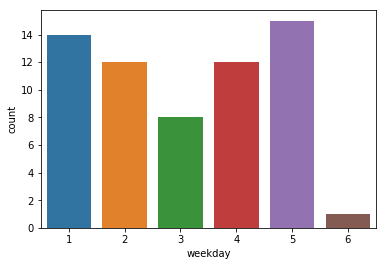

In [132]:
seaborn.countplot(vacancies.weekday)

## Keywords

In [55]:
rex = re.compile(r'[A-Za-z ]{3,}')

In [79]:
keywords = []
for vid in vacancies['id']:
    response = requests.get(
        BASE_URL + '/vacancies/{vacancy_id}'.format(vacancy_id=vid),
        headers={'User-Agent': generate_user_agent()},
    )
    text = response.json()['description']
    text = BeautifulSoup(text, 'html.parser').get_text()
    keywords.extend(rex.findall(text))

In [80]:
keywords = [kw.lower().strip() for kw in keywords]
keywords = [kw for kw in keywords if kw]

In [81]:
keywords_dataframe = pandas.DataFrame(Counter(keywords).most_common(40), columns=['keyword', 'count'])

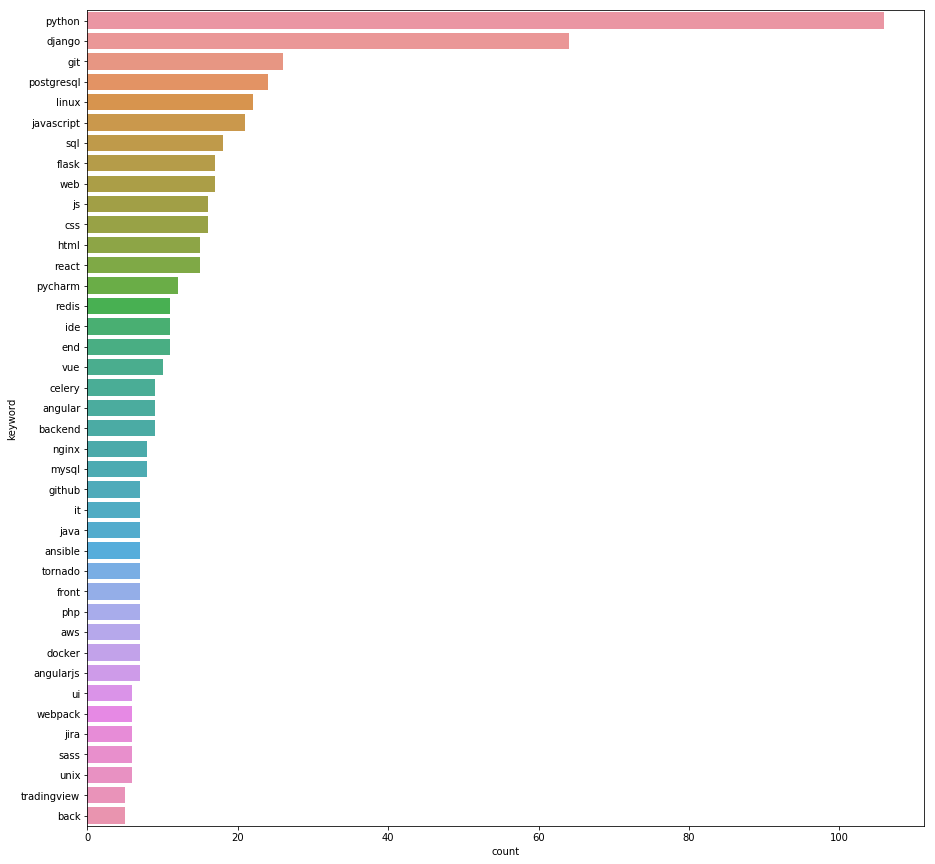

In [90]:
a4_dims = (15, 15)
fig, ax = plt.subplots(figsize=a4_dims)

seaborn.barplot(data=keywords_dataframe, x='count', y='keyword', ax=ax)

## Company info

In [123]:
areas = []
cids = set()
for cid, cname in zip(vacancies.company_id, vacancies.company):
    # only unique requests
    if cid in cids:
        continue
    cids.add(cid)

    # retrieve
    params = dict(
        employer_id=cid,
        area=area,
        period=30,
        per_page=0,
        clusters='true',
    )
    response = requests.get(
        BASE_URL + '/vacancies',
        headers={'User-Agent': generate_user_agent()},
        params=params,
    )

    # analize clusters
    for cluster in response.json()['clusters']:
        if cluster['id'] == 'professional_area':
            good = total = 0
            for item in cluster['items']:
                if item['name'] == 'Информационные технологии, интернет, телеком':
                    good += item['count']
                total += item['count']
            areas.append(dict(
                company=cname,
                count=total,
                rate=good / total
            ))

In [124]:
areas_dataframe = pandas.DataFrame(areas, columns=['company', 'count', 'rate'])

Mostly tech companies:

In [127]:
areas_dataframe.sort_values(by='rate', ascending=False)

,company,count,rate
22,Luxoft,27,0.962963
1,JetBrains,68,0.882353
29,DataArt,16,0.875000
19,First Line Software,23,0.869565
4,НИИ МАСШТАБ,21,0.809524
16,БиАйЭй-Технолоджиз,51,0.803922
24,"EPAM Systems, Inc.",46,0.760870
25,TradingView,12,0.666667
2,Cindicator,14,0.642857
17,ЦИАН ГРУПП,11,0.636364
